In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from scipy.stats import ttest_ind
import json

from tqdm import tqdm

## Load Data 

In [58]:
DATASET_DIRECTORY = 'dataset/MovieSummaries/'

# Load actors df 
character_columns = ['Wikipedia_ID','Freebase_ID', 'release_date', 'movie_name','date_of_birth', 'sex' , 'height',
                     'ethnicity', 'actor_name', 'age_at_release', 'character2actor_map_ID', 'character_ID', 'actor_ID']
actors_df = pd.read_csv(DATASET_DIRECTORY + 'character.metadata.tsv', sep='\t',  header=None,names=character_columns,skiprows=1)

# Load movies df
movie_columns = ['Wikipedia_ID','Freebase_ID','name','release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres' ]
movies_df = pd.read_csv(DATASET_DIRECTORY + 'movie.metadata.tsv', sep='\t',  header=None,names=movie_columns,skiprows=1)

# Load plots summaries
with open(DATASET_DIRECTORY + 'plot_summaries.txt' ) as f:
    plot_summaries = f.readlines()

## clean data

In [59]:
movies_df.iloc[0]

Wikipedia_ID                                                    3196793
Freebase_ID                                                   /m/08yl5d
name                  Getting Away with Murder: The JonBenét Ramsey ...
release_date                                                 2000-02-16
box_office_revenue                                                  NaN
runtime                                                            95.0
languages                            {"/m/02h40lc": "English Language"}
countries                     {"/m/09c7w0": "United States of America"}
genres                {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...
Name: 0, dtype: object

In [79]:
actors_df = actors_df[~actors_df['release_date'].isna()]
actors_df = actors_df[~actors_df.sex.isna()]
actors_df = actors_df[~actors_df.age_at_release.isna()]

In [80]:
actors_df.release_date =  [int(val[:4]) if len(str(val)) > 4 else int(val) for val in actors_df.release_date]

In [81]:
actors_start_2013 = actors_df[ actors_df.release_date >= 2013]

In [73]:
movies_df = movies_df[~movies_df.release_date.isna()]
# [ for val in ]
movies_df.release_date = [int(val[:4]) if len(str(val)) > 4 else int(val) for val in movies_df.release_date]
for x in range(2010, 2017):
    year_nb_movies = movies_df[ movies_df['release_date'] == x].shape[0]
    print(f"year {x}: {year_nb_movies} movies")

year 2010: 2022 movies
year 2011: 1824 movies
year 2012: 1194 movies
year 2013: 164 movies
year 2014: 17 movies
year 2015: 4 movies
year 2016: 3 movies


In [49]:

# Using pandas.to_datetime() 

movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], format="%Y-%m-%d")
print(movies_df)


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1010-12-02 00:00:00

In [39]:
# movies_df.release_date.isna().sum()
movies_df.describe()

,Wikipedia_ID,box_office_revenue,runtime
count,8.174000e+04,8.400000e+03,6.129000e+04
mean,1.740804e+07,4.799767e+07,1.118194e+02
std,1.098783e+07,1.121814e+08,4.360106e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323722e+06,2.081215e+06,8.100000e+01
50%,1.777899e+07,1.063551e+07,9.300000e+01
75%,2.715589e+07,4.073253e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Clean / Process Data

In [4]:
# convert genres to a list of genres for each row
movies_df['genres'] = [ [ v for k, v in  json.loads(dico).items() ] for dico in movies_df.genres.values]

In [5]:
def flatten(l):
    """
    method to flatten a list of lists to just a list 
    """
    return [item for sublist in l for item in sublist]


# compute popularity of each genre and sort them in descending order 
genres = flatten(movies_df['genres'].values)
all_genres = set(genres)
unique, counts = np.unique(genres, return_counts=True)
genres_value_counts = sorted(zip(unique, counts), key=lambda t: t[1], reverse=True)

top_genres, nb_appearances = list(map(list, zip(*genres_value_counts)))

In [6]:
# select the number of top genres to analyse keeping only genres that appear more than
# MIN_NUMBER_OF_APPEARANCES times

MIN_NUMBER_OF_APPEARANCES = 5000
nb_genres = ( np.array(nb_appearances) >= MIN_NUMBER_OF_APPEARANCES ).sum()
selected_genres = set(top_genres[:nb_genres])

# for each movie we create nb_genres new columns who contain 1 , 0 ( True / False) values
# depending if the genre of the column appears in the movie genres field
# these new columns are useful for later sex representations by movie genres
present = np.zeros((movies_df.shape[0], len(selected_genres)))

for idx, row in movies_df.iterrows():

    movie_genres = set(row.genres)
    for genre_idx, genre in enumerate(selected_genres):
        present[idx, genre_idx] = int(genre in movie_genres)

for idx, genre in enumerate(selected_genres):    
        movies_df[genre] = present[:, idx]


In [7]:
# merge movies and actors dataframe to study gender representation in different movie genres
to_drop = ['Wikipedia_ID', 'release_date']
actors_movies_df = actors_df.merge(movies_df.drop(columns=to_drop), how='inner', on='Freebase_ID')

## Initial Analyses

In [8]:
# Interested in the number of movies and number of roles
# as well as the number of features per data point
print(f"movies: ( # movies, # features) : {movies_df.shape}")
print(f"actors: ( # actors, # features) : {actors_df.shape}")

movies: ( # movies, # features) : (81740, 22)
actors: ( # actors, # features) : (450668, 13)


In [9]:
# It's important to check how much data is missing 
print("Number of missing features for movies")
print(movies_df[movie_columns].isna().sum())
print()
print("Number of missing features for actors")
print(actors_df.isna().sum())

Number of missing features for movies
Wikipedia_ID              0
Freebase_ID               0
name                      0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
dtype: int64

Number of missing features for actors
Wikipedia_ID                   0
Freebase_ID                    0
release_date                9995
movie_name                257875
date_of_birth             106145
sex                        45609
height                    295845
ethnicity                 344610
actor_name                  1228
age_at_realease           158113
character2actor_map_ID         0
character_ID              257865
actor_ID                     815
dtype: int64


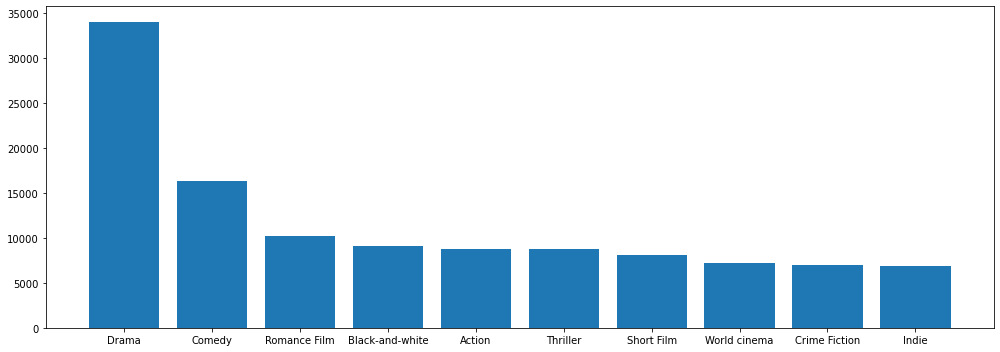

In [10]:
# inspecting the most popular movie genres 
bins = top_genres[:10]
values = nb_appearances[:10]
fig, ax = plt.subplots(figsize = (14,5))
ax.bar(np.arange(len(values)),values)
x = np.arange(len(bins))
ax.set_xticks(x, bins)

plt.tight_layout()
plt.show()

In [11]:
# use the merged data frame ( actors and movies) to then remove rows where the actors sex 
# is not precised, then sum compute for each of the selected movie features 
# the number number of occuerences per sex 
# finally normalize and multiply by 100 to get a percentage for men, women
sex_genre_df = actors_movies_df[~ actors_movies_df['sex'].isna()]
sex_genre_df = pd.DataFrame(sex_genre_df[selected_genres].sum(), columns=['all'])
sex_genre_df['women'] = actors_movies_df[actors_movies_df['sex'] == 'F'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df['men'] = actors_movies_df[actors_movies_df['sex'] == 'M'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df = sex_genre_df.round()

/tmp/ipykernel_317306/1045808997.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df = pd.DataFrame(sex_genre_df[selected_genres].sum(), columns=['all'])
/tmp/ipykernel_317306/1045808997.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df['women'] = actors_movies_df[actors_movies_df['sex'] == 'F'][selected_genres].sum() / sex_genre_df['all'] * 100
/tmp/ipykernel_317306/1045808997.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sex_genre_df['men'] = actors_movies_df[actors_movies_df['sex'] == 'M'][selected_genres].sum() / sex_genre_df['all'] * 100


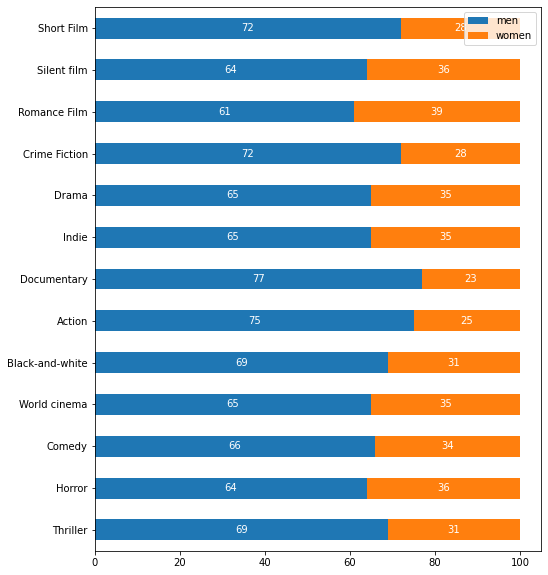

In [12]:
# each whole stacked bar is a 100 units long
# this allows to quickly and easely see the difference in the sex ratio
# between genres
ax = sex_genre_df[['men', 'women']].plot.barh(stacked=True, figsize = (8,10))
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='w')

In [13]:
# we compute how many roles are played by men and women 
print("Role numbers divided by sex")
roles_by_sex = actors_df.sex.value_counts()
print(f"Male roles: {roles_by_sex.loc['M']}, Female roles: {roles_by_sex.loc['F']}")
print(f"{round( roles_by_sex.loc['F'] / (roles_by_sex.loc['F'] + roles_by_sex.loc['M']) * 100, 2)}% of roles are female")

# then we see how many actors are male and how many female
print("\nActors numbers divided by sex")
actors_by_sex = actors_df.groupby('sex').actor_ID.unique().apply(len)
print(f"Male actors: {actors_by_sex.loc['M']}, Female actors: {actors_by_sex.loc['F']}")
print(f"{round( actors_by_sex.loc['F'] / (actors_by_sex.loc['F'] + actors_by_sex.loc['M']) * 100, 2)}% of actors are female")

Role numbers divided by sex
Male roles: 270257, Female roles: 134802
33.28% of roles are female

Actors numbers divided by sex
Male actors: 61519, Female actors: 35864
36.83% of actors are female


In [14]:
# we noticed that some ages at release were negative which is impossible 
# since if you are not born you cannot be in a movie
actors_age_df = actors_df[ ~actors_df['age_at_realease'].isna()]
actors_age_df = actors_age_df[ actors_age_df['age_at_realease'] >= 0]

# we also compute the age of the oldest actor to make sure it's not some crazy big 
# impossible number and use it to specify the number of bins
max_age = int(actors_age_df.age_at_realease.sort_values().max())
print(f"The oldest actor is/was {max_age} years old")

The oldest actor is/was 103 years old


In [40]:
def quartiles(data):
    """
    Method that takes in 1 dimensional data and 
    returns: 1st, second ( median) and 3rd quartile"""
    return [np.quantile(data, x/4) for x in range(1, 4)]

Women        -- 1st quartile 24.0, median 30.0, 3rd quartile 40.0 | IQR: 16.0
Men          -- 1st quartile 31.0, median 39.0, 3rd quartile 49.0 | IQR: 18.0
All Actors   -- 1st quartile 28.0, median 36.0, 3rd quartile 47.0 | IQR: 19.0


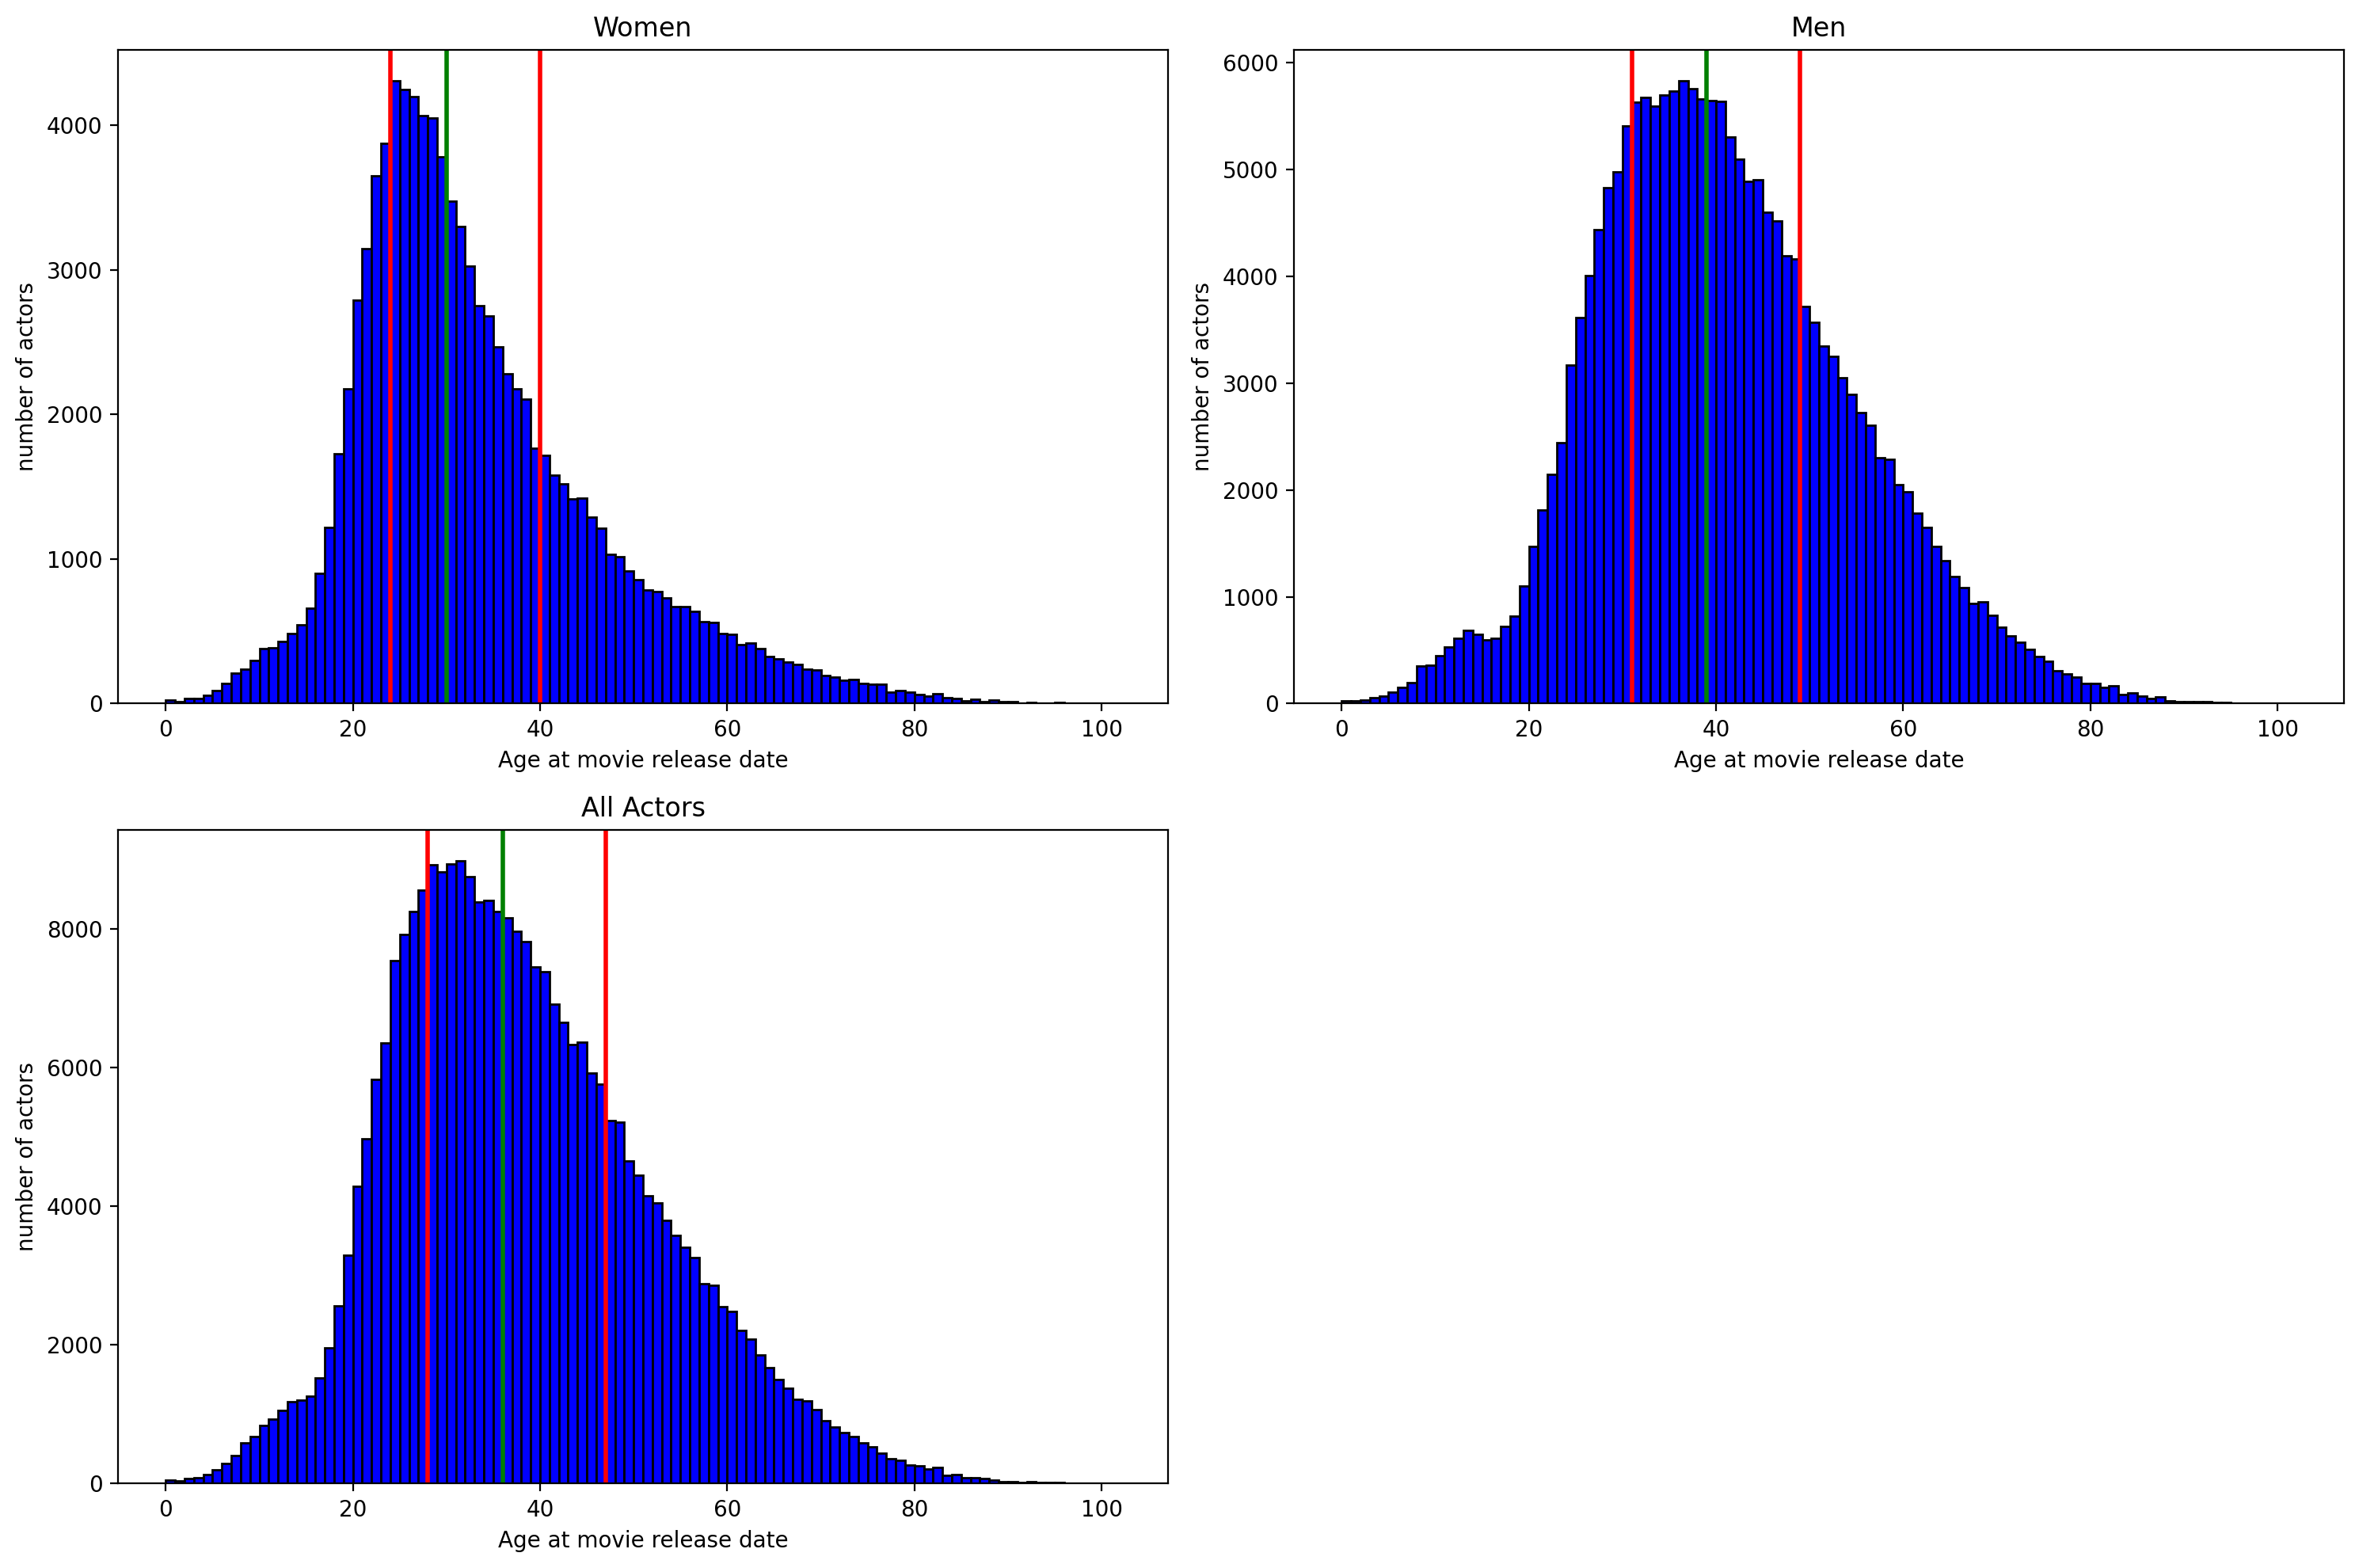

In [16]:
# we then plot the age of the men, women and all the actors at release date of the movie
# We also plot the 1st and 3rd quartile in RED
# and the median in GREEN
# IQR == Interquartile range

categories = [actors_age_df[actors_age_df['sex'] == "F"]['age_at_realease'],
              actors_age_df[actors_age_df['sex'] == "M"]['age_at_realease'],
              actors_age_df['age_at_realease']]

cat_names = [ "Women", "Men", "All Actors"]




figure(figsize=(15, 10), dpi=200)
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(max_age)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(f"{cat_names[i]:12} -- 1st quartile {stats[0]}, median {stats[1]}, 3rd quartile {stats[2]} | IQR: {stats[2] - stats[0]}")
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age at movie release date')
    ax.set_ylabel("number of actors")
    
#     Title and labels
    ax.set_title(cat_names[i])

plt.tight_layout()
plt.show()

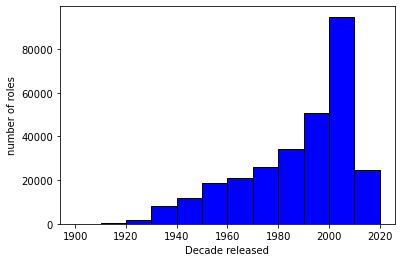

In [17]:
# we also explore the distribution of the roles accross time 
# to know if we have enough data to do sex separation
import datetime
years_apparue = actors_age_df.release_date.astype('datetime64[ns]').dt.year

binwidth = 10
start = int(min(years_apparue/10))*10
end  = (int(max(years_apparue/10))+2)*10
ax = plt.hist(years_apparue, bins=range(start, end , binwidth), color = 'blue', edgecolor = 'black')
plt.xlabel('Decade released')
plt.ylabel("number of roles")
plt.show()


# data bins for each decade from 1900 to 2020

In [18]:
data_bins = [[1900+ 10*x, 1910 + 10*x] for x in range(12)]

# we do the same sex divided plot but for each decade to see the evolution of the age at release distribution

F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles

                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd
[1900, 1910] | 
[1910, 1920] | F:[9.0, 14.0, 16.0]  IQR: 7  | M:[4.0, 6.0, 11.25]  IQR: 7  | A:[6.0, 13.0, 16.0]  IQR: 10 | 
[1920, 1930] | F:[19.0, 21.0, 24.0] IQR: 5  | M:[10.0, 21.0, 25.0] IQR: 15 | A:[18.0, 21.0, 24.0] IQR: 6  | 
[1930, 1940] | F:[21.5, 25.0, 28.0] IQR: 6  | M:[25.0, 30.0, 33.0] IQR: 8  | A:[23.0, 27.0, 31.0] IQR: 8  | 
[1940, 1950] | F:[23.0, 27.0, 33.0] IQR: 10 | M:[29.0, 35.0, 40.0] IQR: 11 | A:[26.0, 32.0, 38.0] IQR: 12 | 
[1950, 1960] | F:[24.0, 29.0, 36.0] IQR: 12 | M:[31.0, 38.0, 45.0] IQR: 14 | A:[28.0, 35.0, 43.0] IQR: 15 | 
[1960, 1970] | F:[24.0, 30.0, 39.0] IQR: 15 | M:[33.0, 40.0, 49.0] IQR: 16 | A:[29.0, 38.0, 46.0] IQR: 17 | 
[1970, 1980] | F:[24.0, 31.0, 41.0] IQR: 17 | M:[32.0, 41.0, 51.0] IQR: 19 | A:[29.0, 38.0, 49.0] IQR: 20 | 
[1980, 1990] | F:[23.0, 31.

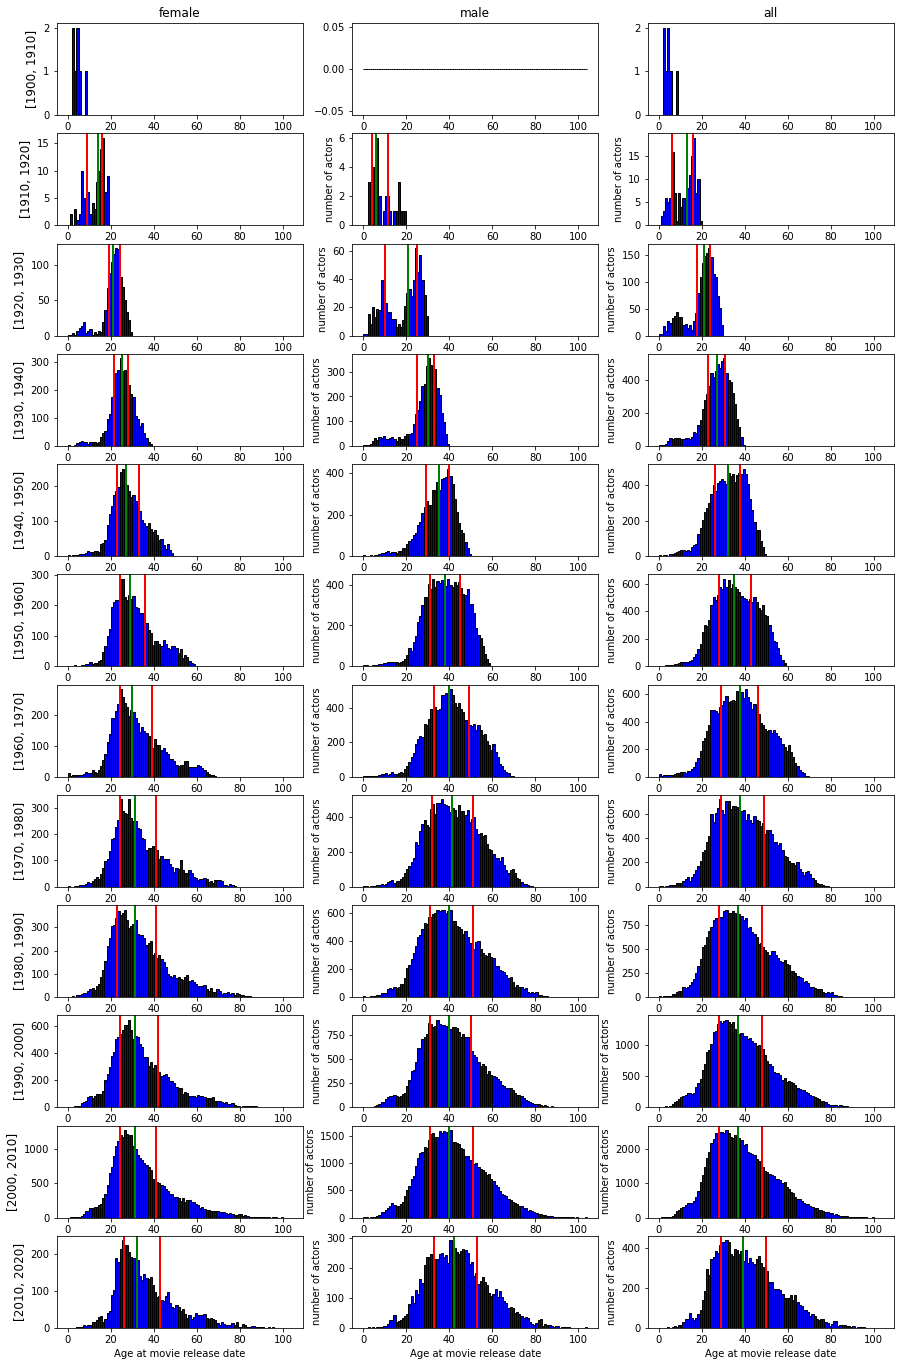

<Figure size 3000x3000 with 0 Axes>

In [19]:




sex_df_dict = {'female': actors_age_df[actors_age_df['sex'] == "F"],
              'male': actors_age_df[actors_age_df['sex'] == "M"],
              'all': actors_age_df}

cat_names = [ "Women", "Men", "All Actors"]


fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(15, 24))

print("F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles\n")
print("                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd")
figure(figsize=(15, 15), dpi=200)
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    for column, sex in enumerate(sex_df_dict.keys()):
        
        # Draw the plot
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        axes[row,column].hist(data, [x for x in range(105)], color = 'blue', edgecolor = 'black')
        data = data.values
        if( data.shape[0] > 10):
            bstats = quartiles(data)
            print( f"{sex[0].upper()}:{str(bstats):18} IQR: {str(int(bstats[2] - bstats[0])):2} | ", end='' )

            axes[row,column].axvline(bstats[0], color='r', linewidth=2)
            axes[row,column].axvline(bstats[1], color='g', linewidth=2)
            axes[row,column].axvline(bstats[2], color='r', linewidth=2)
                
            axes[row,column].set_xlabel('Age at movie release date')
            axes[row,column].set_ylabel("number of actors")


    print()
    
for ax, col in zip(axes[0], sex_df_dict.keys()):
    ax.set_title(col)

for ax, row in zip(axes[:,0], data_bins):
    ax.set_ylabel(row, size='large' )
    
plt.tight_layout()
plt.show()


In [20]:
# we also inspect the ratio of male female roles over time 
ages = np.zeros((len(data_bins), 3))
for row, date_range in enumerate(data_bins):
    for column, sex in enumerate(sex_df_dict.keys()):
        
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        
        ages[row,column] = data.shape[0]

    
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    print( f"Females roles represent: {round(ages[row,0] / ages[row,2]* 100,2):4.2f}% of roles")

[1900, 1910] | Females roles represent: 100.00% of roles
[1910, 1920] | Females roles represent: 73.91% of roles
[1920, 1930] | Females roles represent: 60.39% of roles
[1930, 1940] | Females roles represent: 46.57% of roles
[1940, 1950] | Females roles represent: 35.97% of roles
[1950, 1960] | Females roles represent: 31.60% of roles
[1960, 1970] | Females roles represent: 29.49% of roles
[1970, 1980] | Females roles represent: 30.00% of roles
[1980, 1990] | Females roles represent: 31.18% of roles
[1990, 2000] | Females roles represent: 33.47% of roles
[2000, 2010] | Females roles represent: 35.41% of roles
[2010, 2020] | Females roles represent: 35.50% of roles


In [21]:
# finally we started looking at the actors with the most roles and inspecting their sex
actors_df.groupby(['actor_name', 'sex'])['actor_ID' ].count().sort_values(ascending=False).head(15)#.value_counts()

actor_name          sex
Mel Blanc           M      791
Mithun Chakraborty  M      328
Oliver Hardy        M      299
Mohanlal            M      234
Moe Howard          M      225
Mammootty           M      225
Dharmendra Deol     M      219
Larry Fine          M      219
Amitabh Bachchan    M      206
Prakash Raj         M      205
Brahmanandam        M      204
Kamal Haasan        M      198
Shakti Kapoor       M      191
Harold Lloyd        M      191
Jagathi Sreekumar   M      191
Name: actor_ID, dtype: int64

In [22]:
lgbt_index = np.array([ 'LGBT' in set(row.genres) for idx, row in movies_df.iterrows()])

In [23]:
lgbt_df = movies_df[lgbt_index]

In [24]:
lgbt_df.release_date

158            2000
201      1978-06-16
232      1978-08-31
243            1984
375      2003-09-19
            ...    
81379    1983-12-16
81500          2001
81563          1998
81678          2004
81693          1997
Name: release_date, Length: 1163, dtype: object

In [25]:
lgbt_df = lgbt_df[lgbt_df['release_date'].notna()]


(72,)


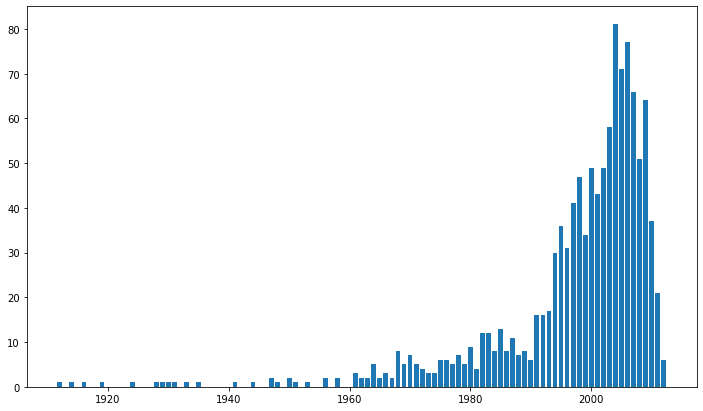

In [26]:
# [datetime.strptime(date, '%Y-%m-%d').year if len(date) > 4 else int(date) for date in lgbt_df.release_date]
lgbt_years = np.array([ int(date[:4]) for date in lgbt_df.release_date])
unique, counts = np.unique(lgbt_years, return_counts=True)
print(unique.shape)
figure(figsize=(12, 7))
_=plt.bar(unique,counts)

In [27]:

movies_df = movies_df[movies_df['release_date'].notna()]
years = np.array([ int(date[:4]) for date in movies_df.release_date])
unique, counts = np.unique(years, return_counts=True)
unique.shape

(130,)

In [28]:
from datetime import datetime
datetime.strptime(lgbt_df.release_date[201], '%Y-%m-%d').year


1978

## 2016

In [40]:
movies_2016 = movies_df[movies_df['release_date'].year == 2016] 

AttributeError: 'Series' object has no attribute 'year'

90.0

Women        -- 1st quartile 27.0, median 32.0, 3rd quartile 41.0 | IQR: 14.0
Men          -- 1st quartile 34.0, median 42.0, 3rd quartile 51.0 | IQR: 17.0
All Actors   -- 1st quartile 31.0, median 39.0, 3rd quartile 49.0 | IQR: 18.0


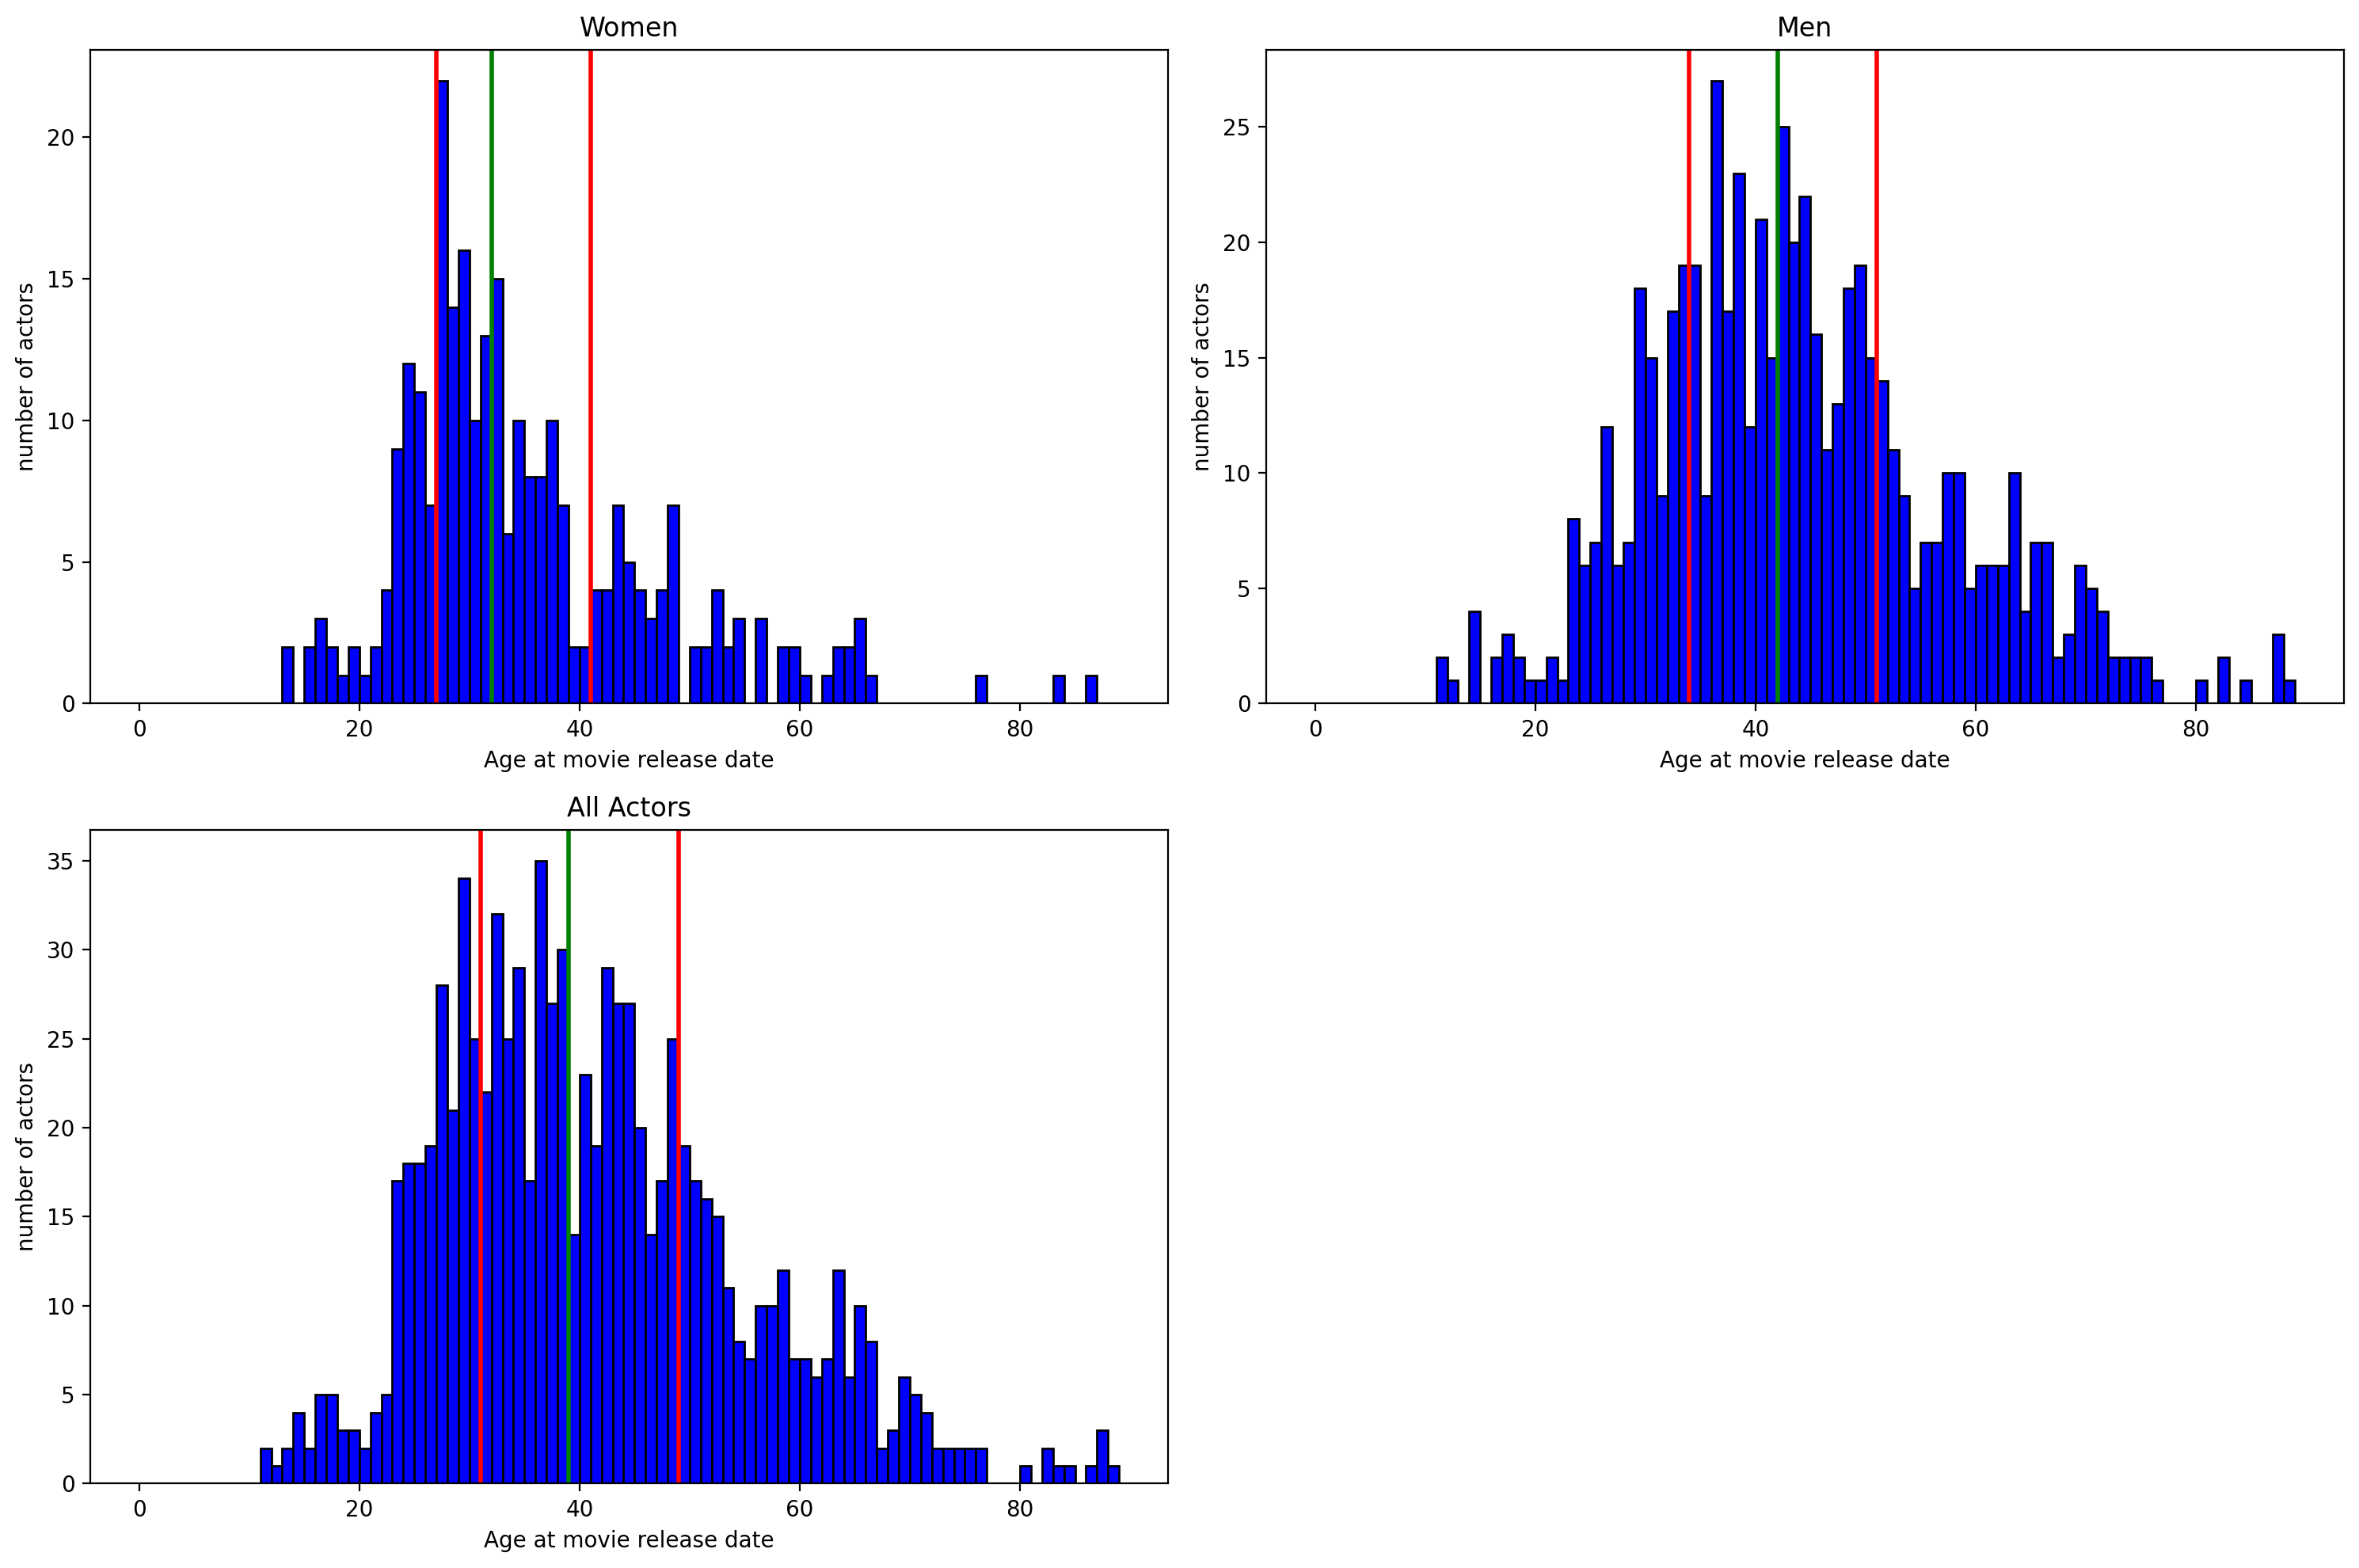

In [41]:
# we then plot the age of the men, women and all the actors at release date of the movie
# We also plot the 1st and 3rd quartile in RED
# and the median in GREEN
# IQR == Interquartile range

categories = [actors_start_2013[actors_start_2013['sex'] == "F"]['age_at_realease'],
              actors_start_2013[actors_start_2013['sex'] == "M"]['age_at_realease'],
              actors_start_2013['age_at_realease']]

cat_names = [ "Women", "Men", "All Actors"]


max_age = int( actors_start_2013.age_at_realease.max() ) 

figure(figsize=(15, 10), dpi=200)
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(max_age)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(f"{cat_names[i]:12} -- 1st quartile {stats[0]}, median {stats[1]}, 3rd quartile {stats[2]} | IQR: {stats[2] - stats[0]}")
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age at movie release date')
    ax.set_ylabel("number of actors")
    
#     Title and labels
    ax.set_title(cat_names[i])

plt.tight_layout()
plt.show()

In [47]:
categories[0].values

array([25., 28., 35., 28., 33., 38., 15., 58., 56., 24., 47., 31., 32.,
       43., 33., 29., 23., 27., 43., 64., 25., 58., 25., 31., 31., 36.,
       30., 27., 52., 45., 32., 25., 63., 37., 19., 44., 35., 31., 54.,
       25., 21., 51., 36., 34., 27., 45., 23., 27., 31., 33., 34., 25.,
       26., 22., 48., 42., 27., 27., 23., 27., 52., 29., 56., 41., 29.,
       43., 32., 13., 44., 24., 20., 25., 23., 32., 27., 29., 59., 50.,
       29., 45., 32., 38., 25., 42., 38., 48., 43., 32., 83., 28., 30.,
       41., 16., 24., 35., 40., 30., 28., 27., 24., 37., 45., 30., 22.,
       32., 24., 53., 86., 29., 29., 26., 31., 43., 24., 27., 25., 32.,
       27., 29., 26., 32., 50., 34., 56., 24., 65., 47., 38., 65., 28.,
       33., 34., 34., 41., 29., 24., 43., 23., 43., 17., 29., 30., 28.,
       38., 24., 15., 32., 36., 37., 44., 42., 39., 27., 28., 29., 37.,
       27., 23., 38., 54., 63., 47., 17., 16., 48., 48., 37., 28., 44.,
       26., 31., 32., 31., 27., 32., 28., 33., 32., 23., 65., 36

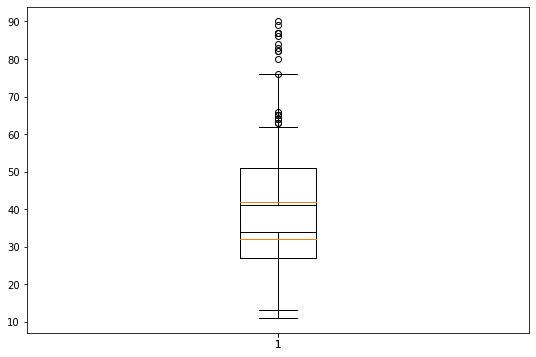

In [52]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(np.array([categories[0].values]))
ax.boxplot(np.array(categories[1].values))

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

/tmp/ipykernel_54836/2642073641.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.vstack(np.array([categories[0].values, categories[1].values]))


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 272 and the array at index 1 has size 607

<AxesSubplot:>

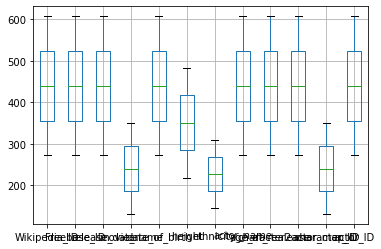

In [55]:
actors_start_2013.groupby('sex').count().boxplot()

In [64]:
actors_start_2013

,Wikipedia_ID,Freebase_ID,release_date,movie_name,date_of_birth,sex,height,ethnicity,actor_name,age_at_release,character2actor_map_ID,character_ID,actor_ID
5322,31338636,/m/0gjcq3r,2013,NaN,1987-06-02,F,1.68,/m/0dryh9k,Sonakshi Sinha,25.0,/m/0gv_w3g,NaN,/m/05sx_xc
5323,31338636,/m/0gjcq3r,2013,NaN,1984-09-29,F,1.68,NaN,Isha Sharvani,28.0,/m/0gx55b9,NaN,/m/0g29qs
5324,31338636,/m/0gjcq3r,2013,NaN,1967-07-27,M,1.70,/m/0bpjh3,Rahul Bose,45.0,/m/0hgvd_2,NaN,/m/06vxph
5325,31338636,/m/0gjcq3r,2013,NaN,1977-02-04,F,NaN,/m/0dryh9k,Pooja Kumar,35.0,/m/0hgvh7f,NaN,/m/02qgdlx
5326,31338636,/m/0gjcq3r,2013,NaN,1985,F,1.72,NaN,Andrea Jeremiah,28.0,/m/0hzvx2z,NaN,/m/02phzmd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
438829,36699915,/m/0d31rqr,2013,Silena Beauregard,1986-06-24,F,1.72,/m/0x67,Solange Knowles,27.0,/m/0hmtwpk,/m/04gjcsm,/m/02ngbf
438830,36699915,/m/0d31rqr,2013,Grover's girlfriend,1985-05-03,F,1.77,NaN,Meagan Tandy,28.0,/m/0hmtwq4,/m/0hmtwxf,/m/0263xhx
442537,34329105,/m/0hz27nt,2013,Christina,1982-04-30,F,1.70,/m/01qhm_,Kirsten Dunst,30.0,/m/0j33kxz,/m/0j33ky1,/m/04fzk
442538,34329105,/m/0hz27nt,2013,Matt,1967-11-22,M,1.73,/m/0xnvg,Mark Ruffalo,45.0,/m/0j33kyk,/m/0j33kyn,/m/035rnz


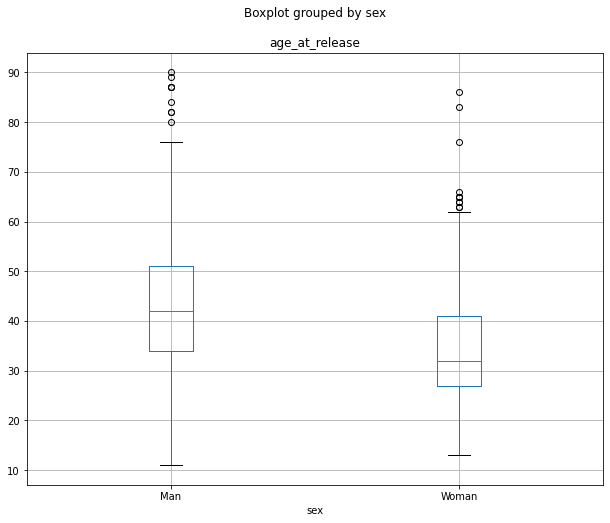

In [87]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
_ = actors_start_2013.boxplot(column=['age_at_release'], by='sex', ax=ax)

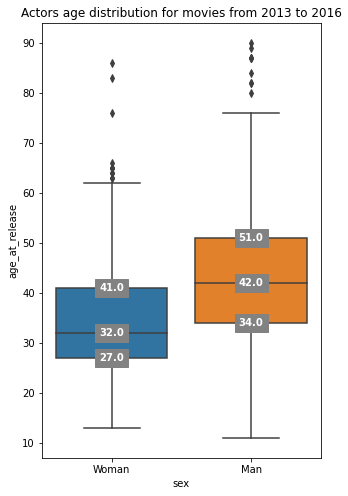

In [114]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(5,8))
plt.suptitle('')
_=sns.boxplot(x='sex', y='age_at_release', data=actors_start_2013, ax=ax).set_title('Actors age distribution for movies from 2013 to 2016')



lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    for x in [0,1,4]:
        y = round(lines[x+cat*6].get_ydata()[0],1) 
        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='semibold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#828282', edgecolor='#828282')
        )
        
fig.savefig("data/from_2013_sex_ages.png") 

In [83]:
actors_start_2013.sex

5322      F
5323      F
5324      M
5325      F
5326      F
         ..
438829    F
438830    F
442537    F
442538    M
442539    M
Name: sex, Length: 879, dtype: object

In [86]:
letter2sex = {"M" : "Man", "F" : "Woman"}
actors_start_2013 = actors_start_2013.replace({"sex": letter2sex})
actors_start_2013

,Wikipedia_ID,Freebase_ID,release_date,movie_name,date_of_birth,sex,height,ethnicity,actor_name,age_at_release,character2actor_map_ID,character_ID,actor_ID
5322,31338636,/m/0gjcq3r,2013,NaN,1987-06-02,Woman,1.68,/m/0dryh9k,Sonakshi Sinha,25.0,/m/0gv_w3g,NaN,/m/05sx_xc
5323,31338636,/m/0gjcq3r,2013,NaN,1984-09-29,Woman,1.68,NaN,Isha Sharvani,28.0,/m/0gx55b9,NaN,/m/0g29qs
5324,31338636,/m/0gjcq3r,2013,NaN,1967-07-27,Man,1.70,/m/0bpjh3,Rahul Bose,45.0,/m/0hgvd_2,NaN,/m/06vxph
5325,31338636,/m/0gjcq3r,2013,NaN,1977-02-04,Woman,NaN,/m/0dryh9k,Pooja Kumar,35.0,/m/0hgvh7f,NaN,/m/02qgdlx
5326,31338636,/m/0gjcq3r,2013,NaN,1985,Woman,1.72,NaN,Andrea Jeremiah,28.0,/m/0hzvx2z,NaN,/m/02phzmd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
438829,36699915,/m/0d31rqr,2013,Silena Beauregard,1986-06-24,Woman,1.72,/m/0x67,Solange Knowles,27.0,/m/0hmtwpk,/m/04gjcsm,/m/02ngbf
438830,36699915,/m/0d31rqr,2013,Grover's girlfriend,1985-05-03,Woman,1.77,NaN,Meagan Tandy,28.0,/m/0hmtwq4,/m/0hmtwxf,/m/0263xhx
442537,34329105,/m/0hz27nt,2013,Christina,1982-04-30,Woman,1.70,/m/01qhm_,Kirsten Dunst,30.0,/m/0j33kxz,/m/0j33ky1,/m/04fzk
442538,34329105,/m/0hz27nt,2013,Matt,1967-11-22,Man,1.73,/m/0xnvg,Mark Ruffalo,45.0,/m/0j33kyk,/m/0j33kyn,/m/035rnz


In [84]:

actors_start_2013['sex'] = actors_start_2013['sex'].replace(['M', 'F'], ['Man', 'Woman'])

/tmp/ipykernel_54836/614398457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_start_2013['sex'] = actors_start_2013['sex'].replace(['M', 'F'], ['Man', 'Woman'])
